## 任务四

In [1]:
"""
    数据的读取 & 预处理
"""
import os
import torch
from torchvision import transforms
from torch.utils.data import Dataset
import numpy as np
import PIL.Image as Image

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
TRAIN_BOARDER = 112
FOLDER_LIST = ['I', 'II']

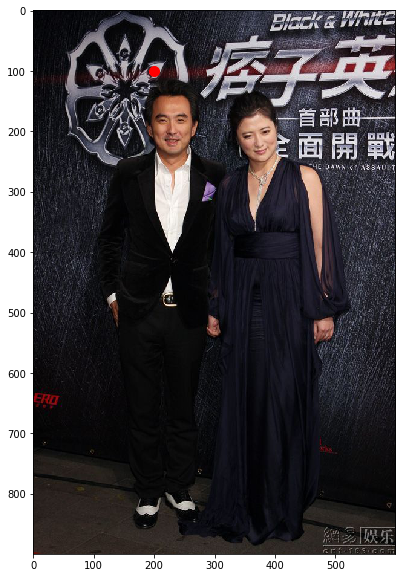

In [27]:
image_name = 'C:/Users/Thinkpad X1 Carbon/Desktop/Deep-Learning-CV-master//Project03_Face_Keypoints_Detection//data//I//000032.jpg'
image = Image.open(image_name)
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.scatter(x=200, y=100, s=100, c='r')
plt.show()

In [28]:
w, h = image.size
w, h

(600, 900)

In [29]:
def channel_norm(img):
    """
    Channel normalization: (image - mean) / std_variation
    :param img: numpy.ndarray, dtype=float32, (h, w, c)
    :return: channel normalized img
    """
    mean = np.mean(img)  # mean of the flattened array
    std = np.std(img)
    pixels = (img - mean) / (std + 1e-8)
    return pixels

In [30]:
image_resize = np.asarray(
    image.resize((TRAIN_BOARDER, TRAIN_BOARDER),  # (width, height)
                 Image.BILINEAR),  # 双线性插值
    dtype=np.float32)
image_resize = channel_norm(image_resize)

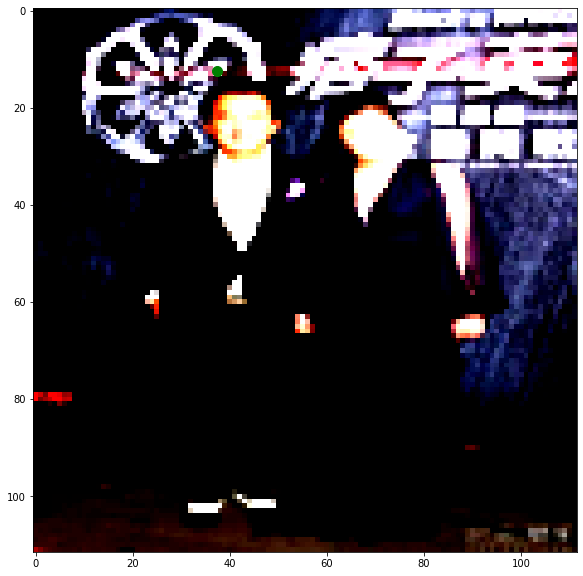

In [31]:
plt.figure(figsize=(10, 10))
plt.imshow(np.clip(image_resize, 0., 1.))
plt.scatter(x=200*(TRAIN_BOARDER/w), y=100*(TRAIN_BOARDER/h), s=100, c='g')
plt.show()

## Test: my_data.py

In [15]:
def get_train_test_set():
    train_set = load_data("train")
    valid_set = load_data("test")
    return train_set, valid_set


def load_data(phase):
    data_file = phase + ".txt"
    with open(data_file) as f:
        lines = f.readlines()

    if phase in ["Train", "train"]:
        # Composes several transforms together:
        tsfm = transforms.Compose([
            Normalize(),
            ToTensor()])
    else:
        # 数据处理可以与'train'不同
        tsfm = transforms.Compose([
            Normalize(),
            ToTensor()])

    data_set = FaceLandmarksDataset(src_lines=lines, transform=tsfm)
    return data_set


class FaceLandmarksDataset(Dataset):
    # 将定义好的 transform 作用在数据上,返回变换后的数据集
    def __init__(self, src_lines, transform=None, **img_mode):
        """
        Face Landmarks Data Set
        :param src_lines: source data lines
        :param transform: data transformation
        :param img_mode: Image.open image in which mode, optional. E.G: mode = **, matrix = **.
        """
        self.lines = src_lines
        self.img_mode = img_mode
        self.transform = transform

    def __len__(self):
        return len(self.lines)

    def __getitem__(self, idx):
        """

        :param idx: current sample index
        :return: a data sample in type of dict
        """
        image_name, rect, landmarks = parse_line(self.lines[idx])
        file_name = "data//" + FOLDER_LIST[0] + "//" + image_name
        if not os.path.exists(file_name):
            file_name = "data//" + FOLDER_LIST[1] + "//" + image_name
        try:
            img = Image.open(file_name)
        except FileNotFoundError as fe:
            print("[FileNotFoundError] ", fe.strerror+": {}".format(file_name))
            print("Do you want to enter a correct path for image {} or pass it? [Y/N]")
            flag = input()
            while flag not in ['Y', 'N']:
                flag = input()
            if flag == 'Y':
                while not os.path.exists(file_name):
                    print("Please enter a new path: ")
                    file_name = input()
                img = Image.open(file_name)
            else:
                return None

        if self.img_mode:
            img = img.convert(self.img_mode)
        """
        模式'L'为灰色图像，每个像素用8个bit表示，0表示黑，255表示白，其他数字表示不同的灰度。
        在PIL中，从模式'RGB'转换为'L'模式是按照下面的公式转换的：
            L = R * 299/1000 + G * 587/1000+ B * 114/1000
        """

        img_crop = img.crop(tuple(rect))
        w, h = img_crop.size

        # 1.image transform
        img = self.transform(img_crop)
        # 2.remap landmarks to transformed image
        landmarks = remap_landmarks_totensor(landmarks, src_w=w, src_h=h)

        sample = {'image': img, 'landmarks': landmarks}
        return sample


def parse_line(line):
    line_parts = line.strip().split()
    image_name = line_parts[0]
    rect = list(map(  # 人脸边框: 由于要crop,需取整
        int,
        list(map(
            float,
            line_parts[1:5]
        ))
    ))
    landmarks = list(map(
        float,
        line_parts[5:len(line_parts)]
    ))
    return image_name, rect, landmarks


class Normalize(object):
    """
        Resize to (train_boarder x train_boarder). Here we use 112 x 112.
        Then do channel normalization: (image - mean) / std_variation
    """
    def __call__(self, image):
        # image, landmarks = sample['image'], sample['landmarks']
        # Ndarray image: shape = (h, w, c)
        image_resize = np.asarray(
            image.resize((TRAIN_BOARDER, TRAIN_BOARDER),  # (width, height)
                         Image.BILINEAR),  # 双线性插值 Image.ANTIALIAS: 1
            dtype=np.float32)
        image = channel_norm(image_resize)
        # return {'image': image, 'landmarks': landmarks}

        return image


def channel_norm(img):
    """
    Channel normalization: (image - mean) / std_variation
    :param img: numpy.ndarray, dtype=float32, (h, w, c)
    :return: channel normalized img
    """
    mean = np.mean(img)  # mean of the flattened array
    std = np.std(img)
    pixels = (img - mean) / (std + 1e-8)
    return pixels


class ToTensor(object):
    def __call__(self, image):
        # image, landmarks = sample['image'], sample['landmarks']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        assert image.ndim in [2, 3]
        if image.ndim == 2:
            # tensor shape: 1 X H X W
            image = np.expand_dims(image, axis=0)
        else:  # image.dim == 3
            image = image.transpose((2, 0, 1))
        # return {'image': torch.from_numpy(image), 'landmarks': torch.from_numpy(landmarks)}
        return torch.from_numpy(image)


def remap_landmarks_totensor(landmarks, **src_size):
    w, h = src_size.values()
    landmarks = np.asarray(landmarks).reshape((-1, 2))
    landmarks *= (TRAIN_BOARDER / w, TRAIN_BOARDER / h)
    return torch.from_numpy(landmarks.ravel())

## 任务五

In [16]:
train_set = load_data("train")
train_set[0]

{'image': tensor([[[ 0.9678,  0.9524,  0.9524,  ..., -1.7295, -1.7449, -1.7449],
          [ 0.9524,  0.9370,  0.9370,  ..., -1.7140, -1.7449, -1.7449],
          [ 0.9370,  0.9062,  0.9216,  ..., -1.7140, -1.7449, -1.7449],
          ...,
          [-0.1727, -0.2036, -0.2806,  ...,  1.5689,  0.8291, -0.5272],
          [-0.1419, -0.2036, -0.2190,  ...,  1.1528, -0.2498, -1.2671],
          [-0.1573, -0.1573, -0.2498,  ...,  0.3975, -1.1592, -1.5137]],
 
         [[ 1.7385,  1.7230,  1.7230,  ..., -1.7295, -1.7449, -1.7449],
          [ 1.7230,  1.7230,  1.7230,  ..., -1.7449, -1.7449, -1.7449],
          [ 1.7076,  1.7230,  1.7230,  ..., -1.7449, -1.7449, -1.7449],
          ...,
          [-0.4039, -0.4656, -0.5427,  ...,  0.9832,  0.4284, -0.8509],
          [-0.3731, -0.4502, -0.4810,  ...,  0.6133, -0.4656, -1.4520],
          [-0.3885, -0.4039, -0.4964,  ..., -0.0803, -1.2208, -1.5753]],
 
         [[ 1.7539,  1.7385,  1.7693,  ..., -1.7449, -1.7449, -1.7449],
          [ 1.7385,

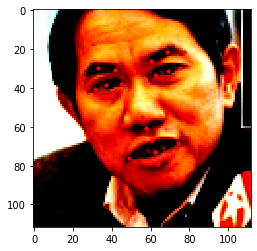

In [26]:
sample = train_set[0]
img, landmarks = sample.values()

# torch image: C X H X W
# numpy image: H x W x C
img = np.array(img).transpose((1, 2, 0))
landmarks = np.array(landmarks).reshape(-1, 2)

plt.figure()
plt.imshow(np.clip(img, 0., 1.))
for x, y in landmarks:
    plt.gca().scatter(x, y, c='r', s=10)
plt.show()

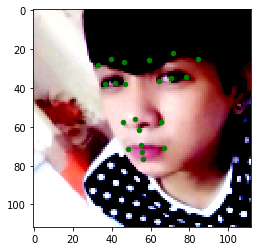

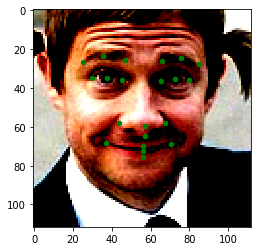

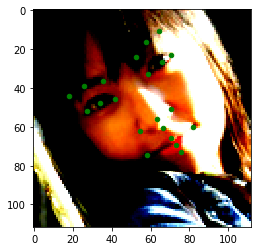

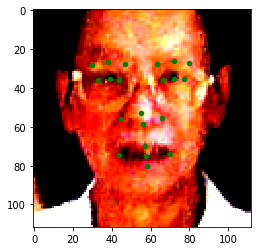

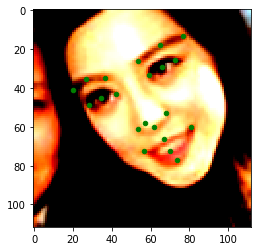

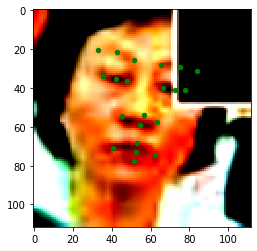

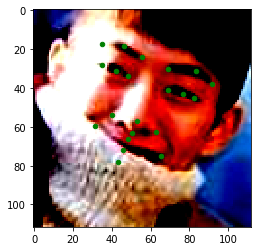

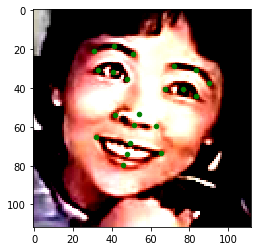

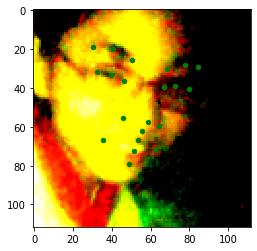

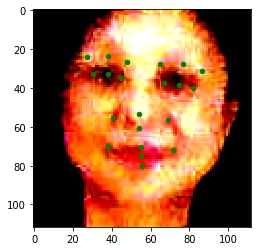

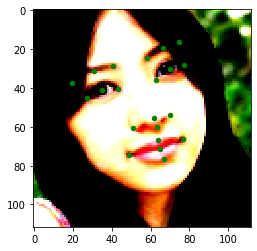

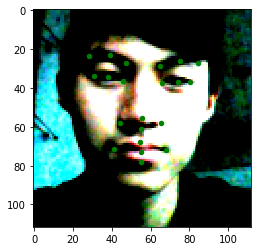

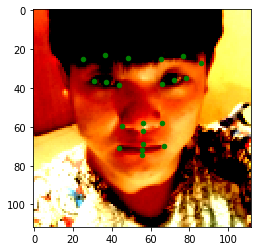

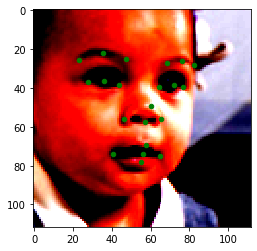

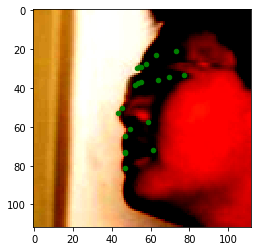

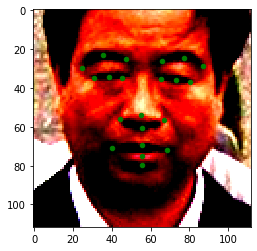

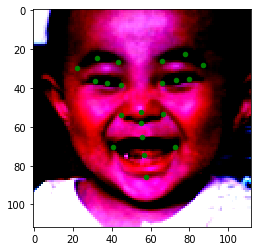

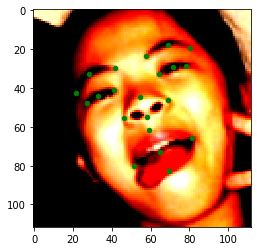

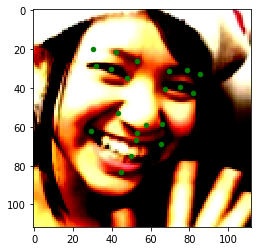

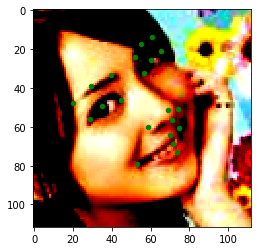

In [36]:
for i in np.random.randint(low=0, high=len(train_set), size=20):
    sample = train_set[i]
    img, landmarks = sample.values()
    
    img = np.array(img).transpose((1, 2, 0))
    landmarks = np.array(landmarks).reshape(-1, 2)

    plt.figure()
    plt.imshow(np.clip(img, 0., 1.))
    for x, y in landmarks:
        plt.gca().scatter(x, y, c='g', s=20)
    plt.show()